## Calculate Seasonal ENSO Skill

### In this example, we demonstrate: 
1. How to remotely access data from the North American Multi-model Ensemble (NMME) hindcast database and set it up to be used in `climpred`
2. How to calculate the Anomaly Correlation Coefficient (ACC) using seasonal data

### The North American Multi-model Ensemble (NMME)

Further information on NMME is available from [Kirtman et al. 2014](https://journals.ametsoc.org/doi/full/10.1175/BAMS-D-12-00050.1) and the [NMME project website](https://www.cpc.ncep.noaa.gov/products/NMME/)

The NMME public database is hosted on the International Research Institute for Climate and Society (IRI) data server http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/

### Definitions

Anomalies
: Departure from normal, where normal is defined as the climatological value based on the average value for each month over all years.

Nino3.4
: An index used to represent the evolution of the El Nino-Southern Oscillation (ENSO). Calculated as the average sea surface temperature (SST) anomalies in the region 5S-5N; 190-240

In [1]:
import warnings

import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

from climpred import HindcastEnsemble
import climpred

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

Load the monthly sea surface temperature (SST) hindcast data for the NCEP-CFSv2 model from the data server

In [4]:
# Get NMME data for NCEP-CFSv2, SST
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/dods'
fcstds = decode_cf(xr.open_dataset(url, decode_times=False, chunks={'S': 1, 'L': 12}), 'S')
fcstds

<xarray.Dataset>
Dimensions:  (L: 10, M: 24, S: 348, X: 360, Y: 181)
Coordinates:
  * S        (S) object 1982-01-01 00:00:00 ... 2010-12-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 20.0 21.0 22.0 23.0 24.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (S, L, M, Y, X) float32 dask.array<chunksize=(1, 10, 24, 181, 360), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL

The NMME data dimensions correspond to the following `climpred` dimension definitions: `X=lon`,`L=lead`,`Y=lat`,`M=member`, `S=init`.  We will rename the dimensions to their `climpred` names.

In [5]:
fcstds=fcstds.rename({'S': 'init','L': 'lead','M': 'member', 'X': 'lon', 'Y': 'lat'})

Let's make sure that the `lead` dimension is set properly for `climpred`.  NMME data stores `leads` as 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... months since initialization. We will change the `lead` to be integers starting with zero.

In [6]:
fcstds['lead']=(fcstds['lead']-0.5).astype('int')

Now we need to make sure that the `init` dimension is set properly for `climpred`.  For monthly data, the `init` dimension must be a `xr.cfdateTimeIndex` or a `pd.datetimeIndex`.  We convert the `init` values to `pd.datatimeIndex`.

In [7]:
fcstds['init']=pd.to_datetime(fcstds.init.values.astype(str))
fcstds['init']=pd.to_datetime(fcstds['init'].dt.strftime('%Y%m01 00:00'))

Next, we want to get the verification SST data from the data server

In [8]:
obsurl='http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.OIv2_SST/.sst/dods'
verifds = decode_cf(xr.open_dataset(obsurl, decode_times=False),'T')
verifds

<xarray.Dataset>
Dimensions:  (T: 405, X: 360, Y: 181)
Coordinates:
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * T        (T) object 1982-01-16 00:00:00 ... 2015-09-16 00:00:00
Data variables:
    sst      (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

Rename the dimensions to correspond to `climpred` dimensions

In [9]:
verifds=verifds.rename({'T': 'time','X': 'lon', 'Y': 'lat'})

Convert the `time` data to be of type `pd.datetimeIndex`

In [10]:
verifds['time']=pd.to_datetime(verifds.time.values.astype(str))
verifds['time']=pd.to_datetime(verifds['time'].dt.strftime('%Y%m01 00:00'))
verifds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 405)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2015-09-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

Subset the data to 1982-2010

In [11]:
verifds=verifds.sel(time=slice('1982-01-01','2010-12-01'))
fcstds=fcstds.sel(init=slice('1982-01-01','2010-12-01'))

Calculate the Nino3.4 index for forecast and verification

In [12]:
fcstnino34=fcstds.sel(lat=slice(-5,5),lon=slice(190,240)).mean(['lat','lon'])
verifnino34=verifds.sel(lat=slice(-5,5),lon=slice(190,240)).mean(['lat','lon'])

fcstclimo = fcstnino34.groupby('init.month').mean('init')
fcstanoms = (fcstnino34.groupby('init.month') - fcstclimo)

verifclimo = verifnino34.groupby('time.month').mean('time')
verifanoms = (verifnino34.groupby('time.month') - verifclimo)

print(fcstanoms)
print(verifanoms)

<xarray.Dataset>
Dimensions:  (init: 348, lead: 10, member: 24)
Coordinates:
  * member   (member) float32 1.0 2.0 3.0 4.0 5.0 ... 20.0 21.0 22.0 23.0 24.0
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 9
  * init     (init) datetime64[ns] 1982-01-01 1982-02-01 ... 2010-12-01
    month    (init) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (init, lead, member) float32 dask.array<chunksize=(1, 10, 24), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (time: 348)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2010-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 0.14492226 -0.044160843 ... -1.5685654 -1.6083965


Make Seasonal Averages with center=True and drop NaNs.  This means that the first value 

In [13]:
fcstnino34seas=fcstanoms.rolling(lead=3, center=True).mean().dropna(dim='lead')
verifnino34seas=verifanoms.rolling(time=3, center=True).mean().dropna(dim='time')

Create new `xr.DataArray` with seasonal data

In [14]:
nleads=fcstnino34seas['lead'][::3].size
fcst=xr.DataArray(fcstnino34seas['sst'][:,::3,:], 
                           coords={'init' : fcstnino34seas['init'],
                                   'lead': np.arange(0,nleads),
                                   'member': fcstanoms['member'],
                                   },
                           dims=['init','lead','member'])
fcst.name = 'sst'

Assign the `units` attribute of `seasons` to the `lead` dimension

In [15]:
fcst['lead'].attrs={'units': 'seasons'}

Create a `climpred HindcastEnsemble` object

In [16]:
hindcast = HindcastEnsemble(fcst)
hindcast = hindcast.add_reference(verifnino34seas, 'observations')

Compute the Anomaly Correlation Coefficient (ACC) 0, 1, 2, and 3 season lead-times

In [17]:
skillds = hindcast.compute_metric(metric='acc')
print(skillds)

<xarray.Dataset>
Dimensions:  (lead: 3)
Coordinates:
  * lead     (lead) int64 0 1 2
Data variables:
    sst      (lead) float64 0.78 0.76 0.6575
Attributes:
    prediction_skill:              calculated by climpred https://climpred.re...
    skill_calculated_by_function:  compute_hindcast
    number_of_initializations:     348
    number_of_members:             24
    metric:                        pearson_r
    comparison:                    e2r
    units:                         None
    created:                       2020-01-03 11:17:38


Make bar plot of Nino3.4 skill for 0,1, and 2 season lead times

Text(0, 0.5, 'ACC')

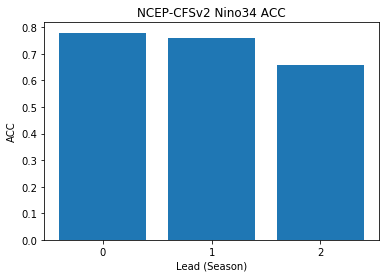

In [18]:
x=np.arange(0,nleads,1.0).astype(int)
plt.bar(x,skillds['sst'])
plt.xticks(x)
plt.title('NCEP-CFSv2 Nino34 ACC')
plt.xlabel('Lead (Season)')
plt.ylabel('ACC')

### References

1. Kirtman, B.P., D. Min, J.M. Infanti, J.L. Kinter, D.A. Paolino, Q. Zhang, H. van den Dool, S. Saha, M.P. Mendez, E. Becker, P. Peng, P. Tripp, J. Huang, D.G. DeWitt, M.K. Tippett, A.G. Barnston, S. Li, A. Rosati, S.D. Schubert, M. Rienecker, M. Suarez, Z.E. Li, J. Marshak, Y. Lim, J. Tribbia, K. Pegion, W.J. Merryfield, B. Denis, and E.F. Wood, 2014: The North American Multimodel Ensemble: Phase-1 Seasonal-to-Interannual Prediction; Phase-2 toward Developing Intraseasonal Prediction. Bull. Amer. Meteor. Soc., 95, 585–601, https://doi.org/10.1175/BAMS-D-12-00050.1